# Spaceship Titanic dataset (Kaggle)

The models implemented here use the following predictors:

- `Age`: The age of the passenger. [`numeric`]
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. [`numeric`]
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence. [`categorical`]
- `CryoSleep`: Indicates whether the passenger was put into suspended animation. Passengers in cryosleep are confined to their cabins. [`categorical`]
- `Destination`: The planet the passenger will be debarking to. [`categorical`]
- `VIP`: Whether the passenger has paid for special VIP service during the voyage. [`categorical`]
- `group_size_bin`: The size of the group the passenger is travellin with (category: "g1", "g2", "g3", "g4more", for 1, 2, 3 or 4-or-more, respectively). [`categorical`]
- `deck`: The deck information from **Cabin** column. [`categorical`]
- `side`: The side information from **Cabin** column. [`categorical`]

\
Label:
- `Transported`: Whether the passenger was transported to another dimension. [`binary`]

\
The performance of the best model on the test set is: [**`TO EDIT <----------`**]
- Accuracy is 0.??.
- When the model claims a passenger was transported to another dimension, it is correct ??.?? % of the time (precision).
- The model detects ??.?? % of the passengers that were transported to another dimension (recall).
- The F1 score is ??.??.


# Load libraries

In [63]:
from pathlib import Path
import sys
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV

np.random.seed(123)

# Python version
print(f"sys: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

sys: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
numpy: 1.24.2
scipy: 1.10.1
pandas: 1.5.3
matplotlib: 3.7.1


# Load data

In [64]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)
print(f"Shape: {X_y_train.shape}")

Shape: (6954, 14)


In [65]:
print(X_y_train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [66]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB


In [67]:
X_y_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,True
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,False


In [68]:
print(f"shape X_y_train: {X_y_train.shape}")

shape X_y_train: (6954, 14)


In [69]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Transported"], axis=1)
y_train = X_y_train.loc[:, "Transported"].copy()

print(f"shape X_train: {X_train.shape}")
print(f"shape y_train: {y_train.shape}")

shape X_train: (6954, 13)
shape y_train: (6954,)


# Define functions

In [70]:
def add_metrics(dictionary, y, y_pred, mod_name):
    # dictionary: a dictionary to which the metrics are added

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    dictionary[mod_name] = {
        "accuracy": np.round(acc, 3),
        "confusion_matrix": cm,
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "f1_score": np.round(f1, 3)
    }

    return dictionary


def print_metrics(m):
    print(f"Accuracy is {m['accuracy']:.2f}.")
    print(f"When the model claims a passenger was transported to another dimension, it is correct {m['precision']*100} % of the time (precision).")
    print(f"The model detects {m['recall']*100:.2f} % of the passengers that were transported to another dimension (recall).")
    print(f"The F1 score is {m['f1_score']*100:.2f}.")


def display_cm(cm):
    # cm: a confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def compare_models(models):
    mods_table = pd.DataFrame.from_dict(models)
    return mods_table.loc[["accuracy", "precision", "recall", "f1_score"],:]

# Define pipelines

In [71]:
# Define columns to convert
c_cat = ["HomePlanet", "Cabin", "Destination"]
c_str = ["PassengerId", "Name"]
# c_bool = ["CryoSleep", "VIP"]

In [72]:
# Function to convert data type & add column
def convert_df(df_in: pd.DataFrame,
               col_cat: list[str],
               col_str: list[str],
               # col_bool: list[str]
 ) -> pd.DataFrame:
    """Converts the specified columns to categorical, string or bool types."""

    df_out = df_in.copy()

    for column in col_cat:
        df_out[column] = df_out[column].astype("category")
    
    for column in col_str:
        df_out[column] = df_out[column].astype("string")

    # NOTE: EXCLUDED because "SimpleImputer" does not support data with dtype bool
    # for column in col_bool:
    #     df_out[column] = df_out[column].astype("bool")

    return df_out

## CombinedAttributesAdder

Define a class that transforms and select various features.

In [73]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert column type
        X = convert_df(
            df_in=X,
            col_cat=c_cat,
            col_str=c_str,
            #col_bool=c_bool,
        )

        # Add "group" and "group_n"
        X[["group", "group_n"]] = X.PassengerId.str.split("_", expand=True)

        # Add "group_size" (a column with the size of the group)
        count_group_size = (
             X
             .value_counts(["group"], sort=False)
             .rename("group_size")
             .reset_index()
        )
        X = pd.merge(X, count_group_size, how="left", on="group")

        # Add "group_size_bin"
        X.loc[:, "group_size_bin"] = np.nan
        X.loc[X.group_size == 1, "group_size_bin"] = "g1"
        X.loc[X.group_size == 2, "group_size_bin"] = "g2"
        X.loc[X.group_size == 3, "group_size_bin"] = "g3"
        X.loc[X.group_size >= 4, "group_size_bin"] = "g4more"
        X["group_size_bin"] = X["group_size_bin"].astype("category")

        # Add "deck", "num" and "side"
        X[["deck", "num", "side"]] = X.Cabin.str.split("/", expand=True)
        X["deck"] = X["deck"].astype("category")
        X["num"] = X["num"].astype("string")
        X["side"] = X["side"].astype("category")
        
        # Drop unused columns
        cols_to_drop = ['PassengerId', 'Cabin', 'Name', 'group',
                        'group_n', 'group_size', 'num']
        X.drop(columns=cols_to_drop, inplace=True)

        return X

## num_pipeline

It preprocesses the numerical attributes with `SimpleImputer()` and `StandardScaler()`.

In [74]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

## cat_pipeline

It preprocesses the categorical attributed with `SimpleImputer()` and `OneHotEncoder()`.

In [75]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))
    ])

## Combine pipelines

In [76]:
list_num_attribs = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP", "group_size_bin", "deck", "side"]

In [77]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs),
    ])

In [78]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [79]:
# print(full_pipeline.get_params().keys())
# print(full_pipeline.get_params().items())
print(full_pipeline.get_params())


{'memory': None, 'steps': [('attribs_adder', CombinedAttributesAdder()), ('cols_transformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'group_size_bin', 'deck', 'side'])]))], 'verbose': False,

In [80]:
for i in full_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
attribs_adder
cols_transformer
cols_transformer__n_jobs
cols_transformer__remainder
cols_transformer__sparse_threshold
cols_transformer__transformer_weights
cols_transformer__transformers
cols_transformer__verbose
cols_transformer__verbose_feature_names_out
cols_transformer__num
cols_transformer__cat
cols_transformer__num__memory
cols_transformer__num__steps
cols_transformer__num__verbose
cols_transformer__num__imputer
cols_transformer__num__std_scaler
cols_transformer__num__imputer__add_indicator
cols_transformer__num__imputer__copy
cols_transformer__num__imputer__fill_value
cols_transformer__num__imputer__keep_empty_features
cols_transformer__num__imputer__missing_values
cols_transformer__num__imputer__strategy
cols_transformer__num__imputer__verbose
cols_transformer__num__std_scaler__copy
cols_transformer__num__std_scaler__with_mean
cols_transformer__num__std_scaler__with_std
cols_transformer__cat__memory
cols_transformer__cat__steps
cols_transformer__cat__verbo

# Voting Classifier

In [81]:
log_clf = LogisticRegression(random_state=123)
svm_pk_clf = SVC(kernel="poly", degree=3)
tree_clf = DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=584)

vot_clf = VotingClassifier(
    estimators=[
        ("log_reg", log_clf),
        ('svm_pk', svm_pk_clf),
        ('cat_lr', tree_clf)],
    voting="hard")

clf_vc = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("vc", vot_clf)])

In [82]:
clf_vc.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('vc',
                 VotingClassifier(estimators=[('log_reg',
                                               LogisticRegression(random_state=123)),
                                              ('svm_pk', SVC(kernel='poly')),
                                              ('cat_lr',
                                               DecisionTreeClassifier(max_depth=8,
                                                                      min_samples_leaf=15,
                                                                      random_state=584))]))])

In [83]:
y_pred_vc = clf_vc.predict(X_train)

In [84]:
model_score_vc = dict()
model_score_vc = add_metrics(model_score_vc, y_train, y_pred_vc, "vc_1")

In [85]:
print_metrics(model_score_vc["vc_1"])

Accuracy is 0.80.
When the model claims a passenger was transported to another dimension, it is correct 80.2 % of the time (precision).
The model detects 80.80 % of the passengers that were transported to another dimension (recall).
The F1 score is 80.50.


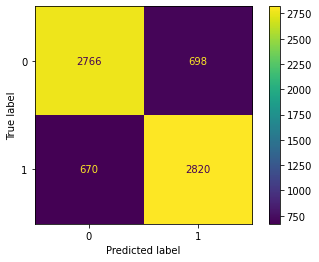

In [86]:
display_cm(model_score_vc["vc_1"]["confusion_matrix"])

# Cross Validation

In [87]:
# Logistic Regression
log_clf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("log", LogisticRegression(random_state=123))])

# SVM
svm_pk_clf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("svm", SVC(kernel="poly", degree=3))])

# Decision Tree
tree_clf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("tree", DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=584))])

# Voting Classifier (hard)
vc_hard = VotingClassifier(
    estimators=[
        ("log_reg", LogisticRegression(random_state=123)),
        ('svm_pk', SVC(kernel="poly", degree=3)),
        ('cat_lr', DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=584))],
    voting="hard")

vc_clf_hard = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("vc", vc_hard)])


# Voting Classifier (soft)
vc_soft = VotingClassifier(
    estimators=[
        ("log_reg", LogisticRegression(random_state=123)),
        ('svm_pk', SVC(kernel="poly", degree=3, probability=True)),
        ('cat_lr', DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=584))],
    voting="soft")

vc_clf_soft = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("vc", vc_soft)])

In [88]:
models = [log_clf, svm_pk_clf, tree_clf, vc_clf_hard, vc_clf_soft]
models_names = ['Logistic Regression', 'SVM poly kernel', 'Decision Tree', 'Voting Classifier (hard)', 'Voting Classifier (soft)']

for clf, label in zip(models, models_names):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

Accuracy: 0.79 (+/- 0.01) [Logistic Regression]
Accuracy: 0.79 (+/- 0.01) [SVM poly kernel]
Accuracy: 0.78 (+/- 0.01) [Decision Tree]
Accuracy: 0.79 (+/- 0.01) [Voting Classifier (hard)]
Accuracy: 0.79 (+/- 0.01) [Voting Classifier (soft)]


# Error analysis

In [89]:
# Voting Classifier (soft)
vc_selected = VotingClassifier(
    estimators=[
        ("log_reg", LogisticRegression(random_state=123)),
        ('svm_pk', SVC(kernel="poly", degree=3, probability=True)),
        ('cat_lr', DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=584))],
    voting="soft")

best_model = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Voting Classifier
    ("vc", vc_selected)])

In [90]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('vc',
                 VotingClassifier(estimators=[('log_reg',
                                               LogisticRegression(random_state=123)),
                                              ('svm_pk',
                                               SVC(kernel='poly',
                                                   probability=True)),
                                              ('cat_lr',
                                               DecisionTreeClassifier(max_depth=8,
                                                                      min_samples_leaf=15,
                                                                      random_state=584))],
                                  voting='soft'))])

In [91]:
y_pred_best_model = best_model.predict(X_train)

In [92]:
model_score = dict()
model_score = add_metrics(model_score, y_train, y_pred_best_model, "vc")

In [93]:
print_metrics(model_score["vc"])

Accuracy is 0.81.
When the model claims a passenger was transported to another dimension, it is correct 80.4 % of the time (precision).
The model detects 81.90 % of the passengers that were transported to another dimension (recall).
The F1 score is 81.20.


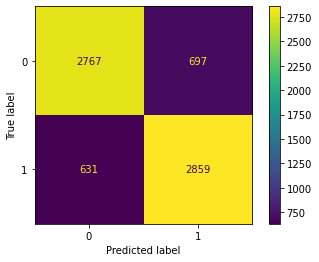

In [94]:
display_cm(model_score["vc"]["confusion_matrix"])

In [95]:
X_train_t = best_model["preparation"].transform(X_train)
X_train_t = pd.DataFrame(X_train_t)
print(f"X_train: {X_train.shape}")
print(f"X_train_t: {X_train_t.shape}")

X_train: (6954, 13)
X_train_t: (6954, 27)


In [96]:
X_train_t

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-7.515461e-01,-0.340282,0.176422,-0.285214,-0.261970,-2.260302e-01,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.256330e-01,-0.340282,-0.293960,-0.288472,-0.273343,-2.656934e-01,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5.048270e-01,-0.340282,-0.293960,-0.288472,-0.273343,-2.656934e-01,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4.025535e-01,-0.340282,-0.293960,-0.288472,-0.273343,-4.796998e-17,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.350285e-01,0.000000,-0.135881,-0.247743,-0.236600,2.882041e+00,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,-1.100539e+00,-0.289576,-0.293317,-0.288472,0.447512,-2.412204e-01,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6950,-5.421506e-01,1.512001,-0.293960,0.776982,-0.273343,-2.656934e-01,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6951,3.017573e+00,3.306120,1.648616,-0.288472,0.342533,-2.488154e-01,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6952,2.256330e-01,-0.340282,-0.293960,-0.288472,-0.273343,-2.656934e-01,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
np.mean(y_train == y_pred_best_model)

0.8090307736554501

In [98]:
X_train["accuracy"] = (y_train == y_pred_best_model)

In [99]:
np.mean(X_train.accuracy)

0.8090307736554501

In [100]:
X_train.loc[:6, :]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,accuracy
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,False
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,True
5,8938_01,NaN,True,F/1729/S,TRAPPIST-1e,22.0,False,0.0,0.0,0.0,0.0,0.0,Quites Must,True
6,3747_04,Europa,True,B/118/P,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Tabiton Ambleetive,True


In [101]:
X_train_err = X_train.loc[X_train.accuracy==False, :].copy()

In [102]:
X_train_err.iloc[:6, :]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,accuracy
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,False
10,1142_01,Earth,False,G/173/P,TRAPPIST-1e,54.0,False,0.0,0.0,0.0,0.0,908.0,Evaned Pugherman,False
15,4003_01,Earth,False,F/827/P,TRAPPIST-1e,22.0,False,1417.0,0.0,0.0,0.0,0.0,NaN,False
16,1133_01,Mars,False,E/64/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Anes Lake,False
17,1670_02,Earth,True,G/269/P,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,0.0,0.0,Jordy Sancasey,False
19,3359_01,Earth,False,G/536/S,TRAPPIST-1e,32.0,False,0.0,810.0,0.0,0.0,2.0,Essara Sweene,False


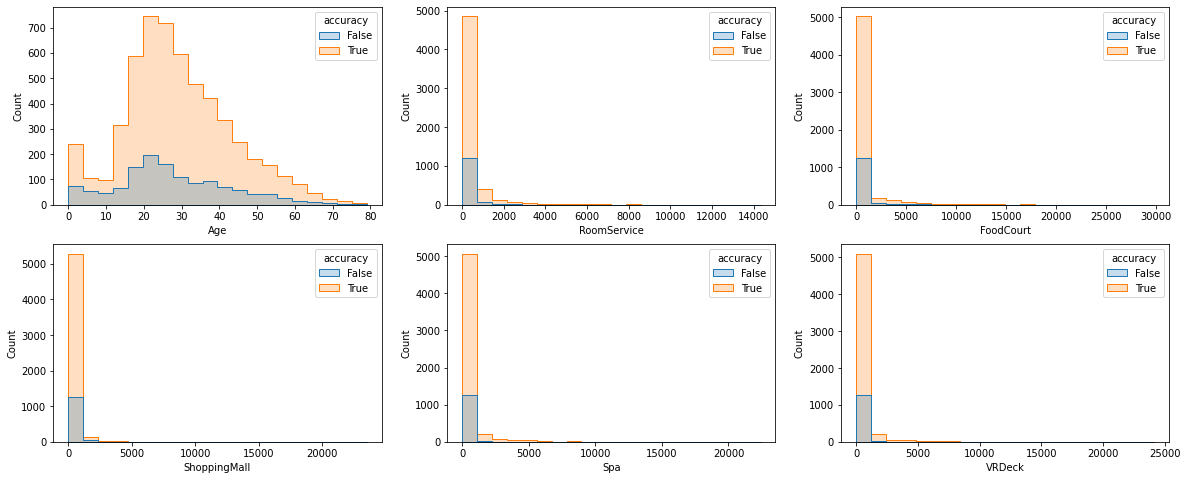

In [103]:
X_num = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
f, axes = plt.subplots(2, 3, figsize=(20, 8))
for ax, feature in zip(axes.flat, X_num):
    sns.histplot(data=X_train, x=feature, bins=20, ax=ax, hue="accuracy", element="step")
plt.show()

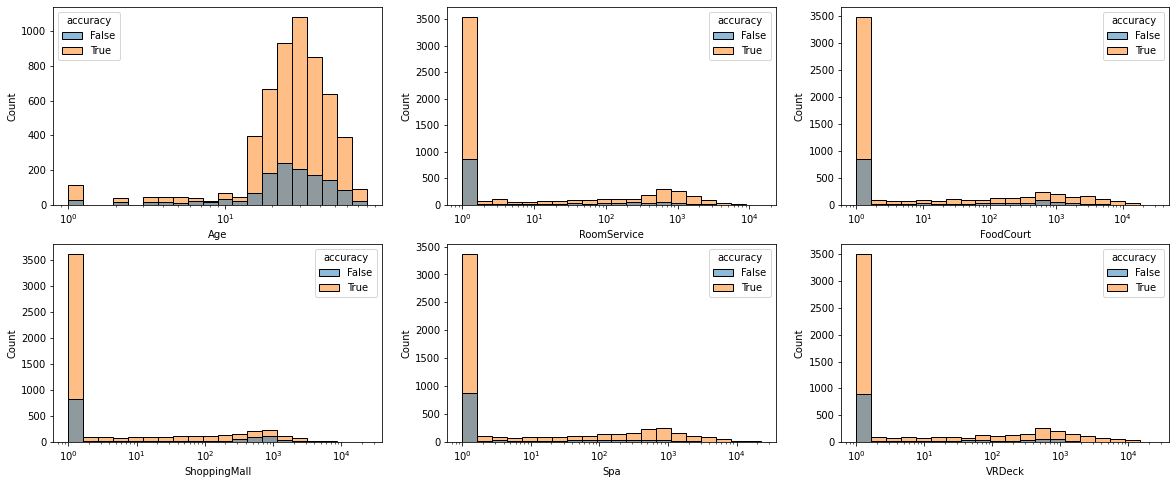

In [104]:
f, axes = plt.subplots(2, 3, figsize=(20, 8))
for ax, feature in zip(axes.flat, X_num):
    x = X_train[feature] + 1
    sns.histplot(x=x, bins=20, ax=ax, hue=X_train["accuracy"], log_scale=True)
plt.show()

In [105]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  accuracy      6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB
